In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

In [2]:
import tensorflow
print (tensorflow.__version__)

2.3.0


Training data shapes: X=(60000, 28, 28), y=(60000,)
Testing data shapes: X=(10000, 28, 28), y=(10000,)


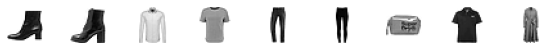

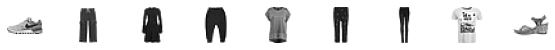

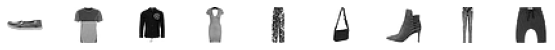

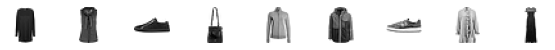

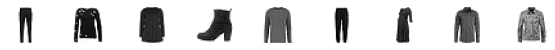

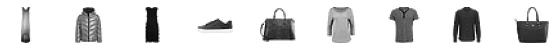

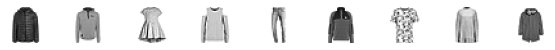

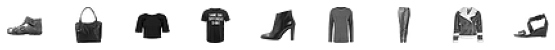

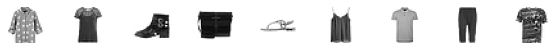

In [3]:
from tensorflow.keras.datasets import fashion_mnist, mnist

(trainX, trainY), (testX, testY) = fashion_mnist.load_data()

print('Training data shapes: X=%s, y=%s' % (trainX.shape, trainY.shape))
print('Testing data shapes: X=%s, y=%s' % (testX.shape, testY.shape))


for k in range(9):
    plt.figure(figsize=(10, 7))
    for j in range(9):
        i = np.random.randint(0, 10000)
        plt.subplot(990 + 1 + j)
        plt.imshow(trainX[i], cmap='gray_r')
        #plt.title(trainY[i])
        plt.axis('off')
    plt.show()

In [4]:
#Ten classes
set(trainY)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [5]:
trainX = [(image-127.5)/127.5 for image in trainX]
testX = [(image-127.5)/127.5 for image in testX]

trainX = np.reshape(trainX, (60000, 28, 28, 1))
testX = np.reshape(testX, (10000, 28, 28, 1))

print (trainX.shape, testX.shape, trainY.shape, testY.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1) (60000,) (10000,)


# Generator Model

In [22]:
random_input = tensorflow.keras.layers.Input(shape = 100)

x = tensorflow.keras.layers.Dense(5*5*64)(random_input)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)

x = tensorflow.keras.layers.Reshape((5, 5, 64))(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=128, kernel_size=(5,5))(x)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=128, kernel_size=(7,7))(x)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=128, kernel_size=(7,7))(x)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=1, kernel_size=(8,8))(x)
generated_image = tensorflow.keras.layers.Activation('tanh')(x)

generator_network = tensorflow.keras.models.Model(inputs=random_input, outputs=generated_image)
generator_network.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1600)              161600    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 1600)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 9, 9, 128)         204928    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 9, 9, 128)         0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 9, 9, 128)       

# Critic

In [23]:
# custom loss function
def wasserstein_loss(y_true, y_pred):
    return tensorflow.keras.backend.mean(y_true * y_pred)

In [24]:
image_input = tensorflow.keras.layers.Input(shape=(28, 28, 1))

x = tensorflow.keras.layers.Conv2D(filters=128, kernel_size=(3,3))(image_input)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)

x = tensorflow.keras.layers.Conv2D(filters=128, kernel_size=(5,5), strides=2)(x)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)

x = tensorflow.keras.layers.Conv2D(filters=128, kernel_size=(5,5))(x)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)

x = tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(7,7))(x)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)

x = tensorflow.keras.layers.Flatten()(x)

c_out = tensorflow.keras.layers.Dense(1)(x)

critic_network = tensorflow.keras.models.Model(inputs=image_input, outputs=c_out)

print (critic_network.summary())

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 26, 26, 128)       1280      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 11, 11, 128)       409728    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 11, 11, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 128)         409728    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 7, 7, 128)       

# Compiling Classisfiers

In [25]:
RMSprop_optimizer = tensorflow.keras.optimizers.RMSprop(lr=0.00005)
critic_network.compile(loss=wasserstein_loss, optimizer=RMSprop_optimizer, metrics=['accuracy'])

# GAN

In [26]:
critic_network.trainable=False

g_output = generator_network(random_input)

c_output = critic_network(g_output)

wgan_model = tensorflow.keras.models.Model(inputs = random_input, outputs = c_output)
wgan_model.summary()

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
functional_11 (Functional)   (None, 28, 28, 1)         1982145   
_________________________________________________________________
functional_13 (Functional)   (None, 1)                 1222273   
Total params: 3,204,418
Trainable params: 1,981,377
Non-trainable params: 1,223,041
_________________________________________________________________


# Compiling InfoGAN

In [27]:
wgan_model.compile(loss=wasserstein_loss, optimizer=RMSprop_optimizer)

# Define Data Generators

In [28]:
indices = [i for i in range(0, len(trainX))]

def get_random_noise(batch_size, noise_size):
    random_values = np.random.randn(batch_size*noise_size)
    random_noise_batches = np.reshape(random_values, (batch_size, noise_size))
    return random_noise_batches

def get_fake_samples(generator_network, batch_size, noise_size):
    random_noise_batches = get_random_noise(batch_size, noise_size) 
    fake_samples = generator_network.predict_on_batch(random_noise_batches)
    return fake_samples

def get_real_samples(batch_size):
    random_indices = np.random.choice(indices, size=batch_size)
    real_images = trainX[np.array(random_indices),:]
    return real_images

def show_generator_results(generator_network):
    for k in range(5):
        plt.figure(figsize=(10, 7))
        random_noise_batches = get_random_noise(5, noise_size) 
        fake_samples = generator_network.predict_on_batch(random_noise_batches)
        for j in range(5):
            i = j
            plt.subplot(550 + 1 + j)
            plt.imshow(((fake_samples[i,:,:,-1])/2.0)+0.5, cmap='gray_r')
            plt.axis('off')
        plt.show()
    return

# Training GAN

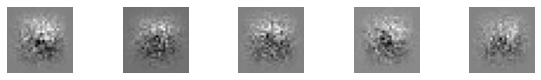

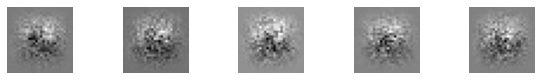

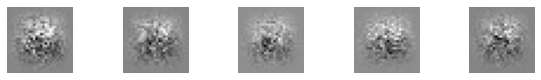

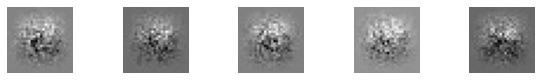

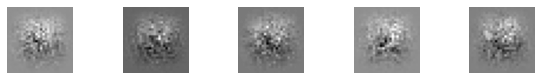

Epoch:0, Step:0, C-Loss:-0.000, G-Loss:-0.000
Epoch:0, Step:50, C-Loss:-0.704, G-Loss:-2.778
Epoch:0, Step:100, C-Loss:-3.542, G-Loss:3.323
Epoch:0, Step:150, C-Loss:-3.023, G-Loss:4.023
Epoch:0, Step:200, C-Loss:0.578, G-Loss:-0.488
Epoch:0, Step:250, C-Loss:0.105, G-Loss:0.416
Epoch:0, Step:300, C-Loss:-0.089, G-Loss:0.208
Epoch:0, Step:350, C-Loss:-0.258, G-Loss:0.448
Epoch:0, Step:400, C-Loss:-0.486, G-Loss:2.651
Epoch:0, Step:450, C-Loss:-0.116, G-Loss:-0.771


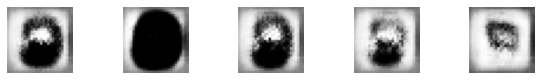

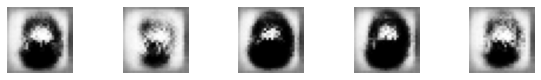

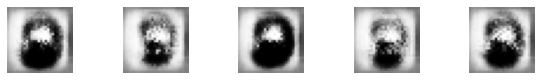

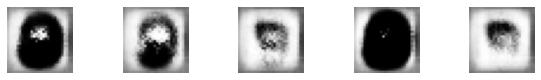

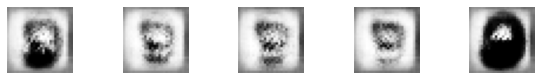

Epoch:1, Step:0, C-Loss:-0.468, G-Loss:-0.029
Epoch:1, Step:50, C-Loss:-0.273, G-Loss:-1.027
Epoch:1, Step:100, C-Loss:-0.065, G-Loss:-1.219
Epoch:1, Step:150, C-Loss:-0.054, G-Loss:-0.756
Epoch:1, Step:200, C-Loss:-0.125, G-Loss:-1.255
Epoch:1, Step:250, C-Loss:-0.178, G-Loss:-0.540
Epoch:1, Step:300, C-Loss:0.054, G-Loss:-1.089
Epoch:1, Step:350, C-Loss:-0.234, G-Loss:-1.192
Epoch:1, Step:400, C-Loss:-0.028, G-Loss:-1.670
Epoch:1, Step:450, C-Loss:-0.004, G-Loss:-1.312


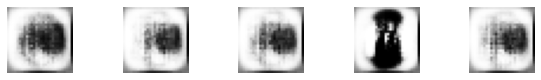

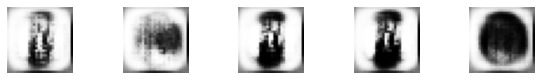

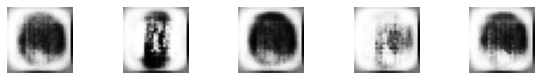

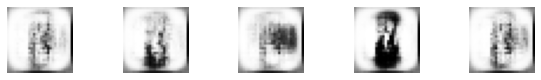

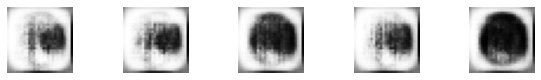

Epoch:2, Step:0, C-Loss:-0.042, G-Loss:-0.989
Epoch:2, Step:50, C-Loss:-0.037, G-Loss:-1.528
Epoch:2, Step:100, C-Loss:-0.137, G-Loss:-0.734
Epoch:2, Step:150, C-Loss:-0.088, G-Loss:-0.834
Epoch:2, Step:200, C-Loss:-0.116, G-Loss:-1.214
Epoch:2, Step:250, C-Loss:-0.053, G-Loss:-0.756
Epoch:2, Step:300, C-Loss:-0.086, G-Loss:-1.181
Epoch:2, Step:350, C-Loss:-0.034, G-Loss:-0.742
Epoch:2, Step:400, C-Loss:-0.033, G-Loss:-0.668
Epoch:2, Step:450, C-Loss:-0.009, G-Loss:-0.727


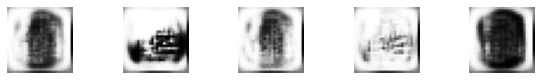

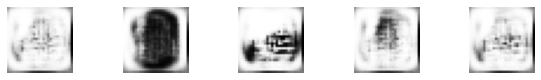

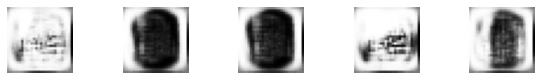

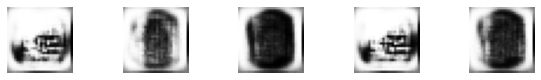

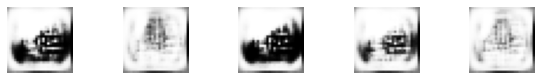

Epoch:3, Step:0, C-Loss:-0.033, G-Loss:-0.686
Epoch:3, Step:50, C-Loss:-0.080, G-Loss:-0.565
Epoch:3, Step:100, C-Loss:-0.038, G-Loss:-0.470
Epoch:3, Step:150, C-Loss:-0.081, G-Loss:-0.553
Epoch:3, Step:200, C-Loss:-0.119, G-Loss:-0.488
Epoch:3, Step:250, C-Loss:-0.105, G-Loss:-0.423
Epoch:3, Step:300, C-Loss:-0.102, G-Loss:-0.516
Epoch:3, Step:350, C-Loss:-0.145, G-Loss:-0.401
Epoch:3, Step:400, C-Loss:-0.180, G-Loss:-0.338
Epoch:3, Step:450, C-Loss:-0.080, G-Loss:-0.371


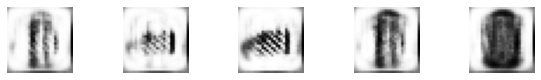

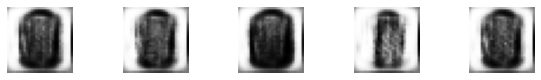

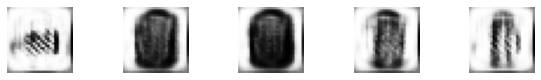

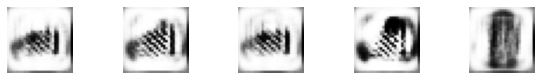

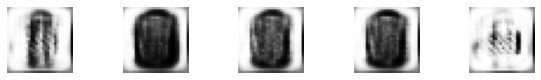

Epoch:4, Step:0, C-Loss:-0.125, G-Loss:-0.079
Epoch:4, Step:50, C-Loss:-0.136, G-Loss:-0.235
Epoch:4, Step:100, C-Loss:-0.137, G-Loss:0.015
Epoch:4, Step:150, C-Loss:-0.196, G-Loss:-0.236
Epoch:4, Step:200, C-Loss:-0.112, G-Loss:0.073
Epoch:4, Step:250, C-Loss:-0.176, G-Loss:-0.124
Epoch:4, Step:300, C-Loss:-0.184, G-Loss:0.143
Epoch:4, Step:350, C-Loss:-0.214, G-Loss:0.190
Epoch:4, Step:400, C-Loss:-0.186, G-Loss:-0.305
Epoch:4, Step:450, C-Loss:-0.097, G-Loss:0.052


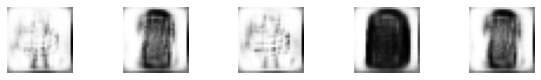

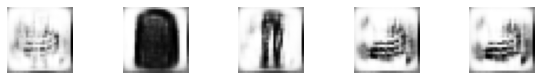

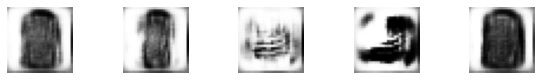

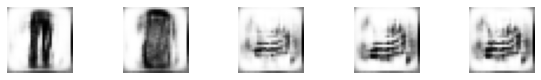

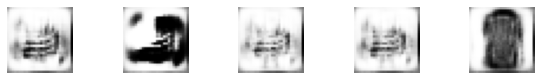

Epoch:5, Step:0, C-Loss:-0.207, G-Loss:0.272
Epoch:5, Step:50, C-Loss:-0.107, G-Loss:-0.056
Epoch:5, Step:100, C-Loss:-0.180, G-Loss:0.273
Epoch:5, Step:150, C-Loss:-0.172, G-Loss:0.197
Epoch:5, Step:200, C-Loss:-0.165, G-Loss:0.024
Epoch:5, Step:250, C-Loss:-0.140, G-Loss:0.216
Epoch:5, Step:300, C-Loss:-0.104, G-Loss:0.044
Epoch:5, Step:350, C-Loss:-0.112, G-Loss:0.171
Epoch:5, Step:400, C-Loss:-0.144, G-Loss:0.326
Epoch:5, Step:450, C-Loss:-0.140, G-Loss:0.314


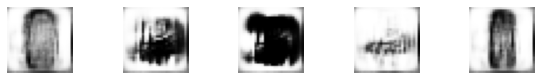

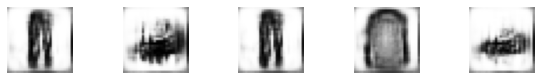

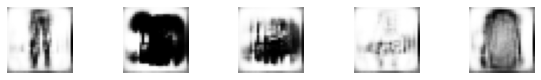

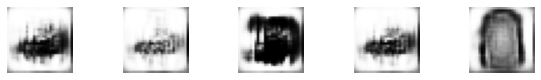

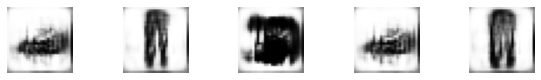

Epoch:6, Step:0, C-Loss:-0.311, G-Loss:0.413
Epoch:6, Step:50, C-Loss:-0.158, G-Loss:0.277
Epoch:6, Step:100, C-Loss:-0.239, G-Loss:0.412
Epoch:6, Step:150, C-Loss:-0.246, G-Loss:0.435
Epoch:6, Step:200, C-Loss:-0.192, G-Loss:0.321
Epoch:6, Step:250, C-Loss:-0.166, G-Loss:0.039
Epoch:6, Step:300, C-Loss:-0.139, G-Loss:0.066
Epoch:6, Step:350, C-Loss:-0.139, G-Loss:0.304
Epoch:6, Step:400, C-Loss:-0.205, G-Loss:0.209
Epoch:6, Step:450, C-Loss:-0.222, G-Loss:0.207


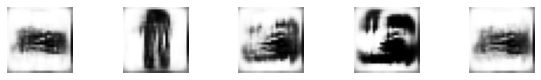

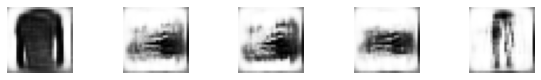

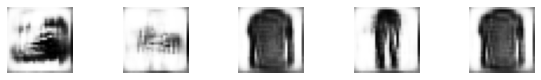

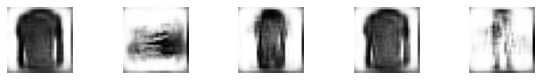

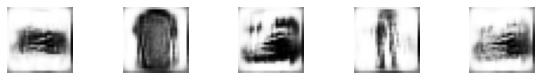

Epoch:7, Step:0, C-Loss:-0.109, G-Loss:0.257
Epoch:7, Step:50, C-Loss:-0.127, G-Loss:0.379
Epoch:7, Step:100, C-Loss:-0.143, G-Loss:0.306
Epoch:7, Step:150, C-Loss:-0.244, G-Loss:0.465
Epoch:7, Step:200, C-Loss:-0.176, G-Loss:0.188
Epoch:7, Step:250, C-Loss:-0.078, G-Loss:0.118
Epoch:7, Step:300, C-Loss:-0.094, G-Loss:0.082
Epoch:7, Step:350, C-Loss:-0.126, G-Loss:0.225
Epoch:7, Step:400, C-Loss:-0.188, G-Loss:0.204
Epoch:7, Step:450, C-Loss:-0.133, G-Loss:0.148


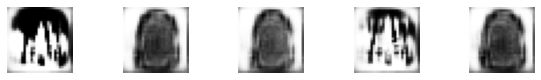

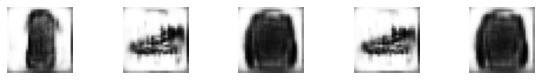

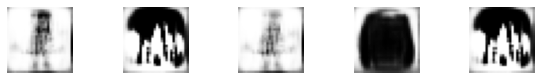

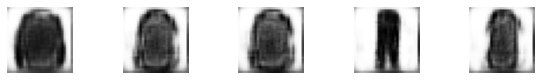

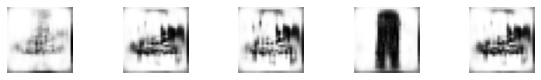

Epoch:8, Step:0, C-Loss:-0.105, G-Loss:0.151
Epoch:8, Step:50, C-Loss:-0.145, G-Loss:0.069
Epoch:8, Step:100, C-Loss:-0.136, G-Loss:0.361
Epoch:8, Step:150, C-Loss:-0.112, G-Loss:0.230
Epoch:8, Step:200, C-Loss:-0.151, G-Loss:0.349
Epoch:8, Step:250, C-Loss:-0.127, G-Loss:0.300
Epoch:8, Step:300, C-Loss:-0.220, G-Loss:0.218
Epoch:8, Step:350, C-Loss:-0.101, G-Loss:0.053
Epoch:8, Step:400, C-Loss:-0.118, G-Loss:0.263
Epoch:8, Step:450, C-Loss:-0.132, G-Loss:0.128


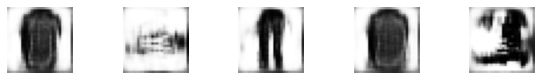

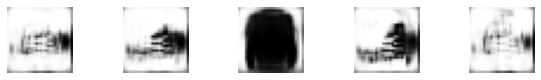

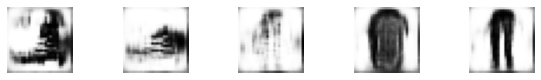

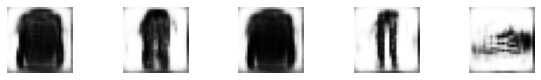

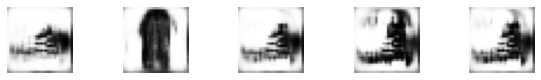

Epoch:9, Step:0, C-Loss:-0.156, G-Loss:0.303
Epoch:9, Step:50, C-Loss:-0.078, G-Loss:0.204
Epoch:9, Step:100, C-Loss:-0.185, G-Loss:0.425
Epoch:9, Step:150, C-Loss:-0.075, G-Loss:0.180
Epoch:9, Step:200, C-Loss:-0.141, G-Loss:0.158
Epoch:9, Step:250, C-Loss:-0.110, G-Loss:0.174
Epoch:9, Step:300, C-Loss:-0.101, G-Loss:0.290
Epoch:9, Step:350, C-Loss:-0.134, G-Loss:0.480
Epoch:9, Step:400, C-Loss:-0.113, G-Loss:0.306
Epoch:9, Step:450, C-Loss:-0.126, G-Loss:0.317


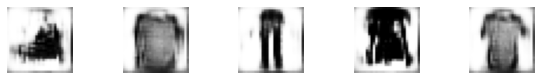

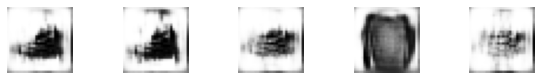

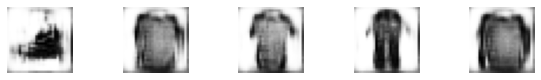

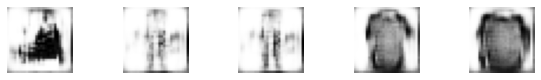

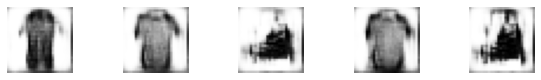

Epoch:10, Step:0, C-Loss:-0.080, G-Loss:0.324
Epoch:10, Step:50, C-Loss:-0.117, G-Loss:0.272
Epoch:10, Step:100, C-Loss:-0.143, G-Loss:0.382
Epoch:10, Step:150, C-Loss:-0.066, G-Loss:0.267
Epoch:10, Step:200, C-Loss:-0.122, G-Loss:0.192
Epoch:10, Step:250, C-Loss:-0.162, G-Loss:0.199
Epoch:10, Step:300, C-Loss:-0.101, G-Loss:0.300
Epoch:10, Step:350, C-Loss:-0.059, G-Loss:0.310
Epoch:10, Step:400, C-Loss:-0.098, G-Loss:0.157
Epoch:10, Step:450, C-Loss:-0.184, G-Loss:0.088


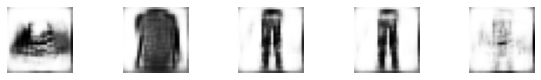

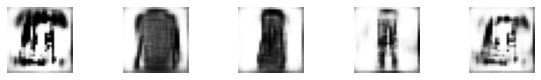

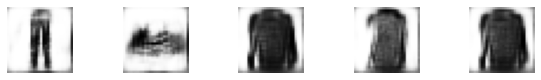

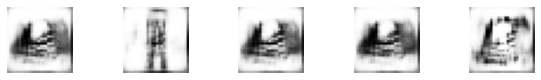

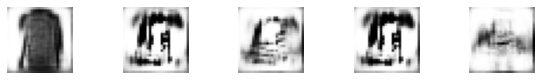

Epoch:11, Step:0, C-Loss:-0.062, G-Loss:0.112
Epoch:11, Step:50, C-Loss:-0.166, G-Loss:0.393
Epoch:11, Step:100, C-Loss:-0.081, G-Loss:0.030
Epoch:11, Step:150, C-Loss:-0.117, G-Loss:0.135
Epoch:11, Step:200, C-Loss:-0.066, G-Loss:0.219
Epoch:11, Step:250, C-Loss:-0.083, G-Loss:0.152
Epoch:11, Step:300, C-Loss:-0.005, G-Loss:0.304
Epoch:11, Step:350, C-Loss:-0.098, G-Loss:0.338
Epoch:11, Step:400, C-Loss:-0.124, G-Loss:0.226
Epoch:11, Step:450, C-Loss:-0.101, G-Loss:0.262


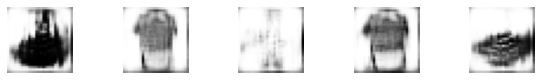

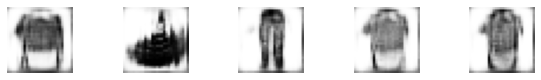

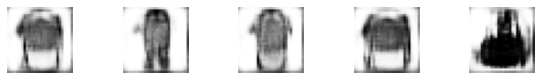

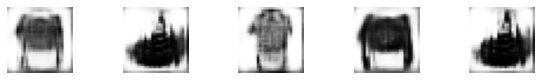

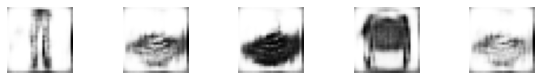

Epoch:12, Step:0, C-Loss:-0.140, G-Loss:0.321
Epoch:12, Step:50, C-Loss:-0.126, G-Loss:0.334
Epoch:12, Step:100, C-Loss:-0.064, G-Loss:0.131
Epoch:12, Step:150, C-Loss:-0.054, G-Loss:0.291
Epoch:12, Step:200, C-Loss:-0.044, G-Loss:0.250
Epoch:12, Step:250, C-Loss:-0.125, G-Loss:0.354
Epoch:12, Step:300, C-Loss:-0.126, G-Loss:0.281
Epoch:12, Step:350, C-Loss:-0.084, G-Loss:0.269
Epoch:12, Step:400, C-Loss:-0.097, G-Loss:0.316
Epoch:12, Step:450, C-Loss:-0.085, G-Loss:0.419


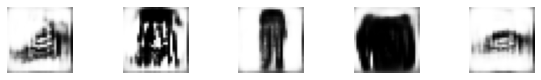

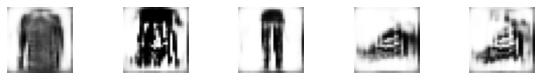

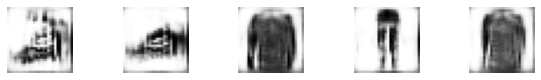

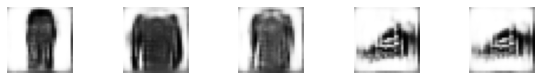

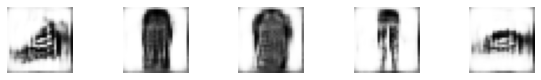

Epoch:13, Step:0, C-Loss:-0.094, G-Loss:0.292
Epoch:13, Step:50, C-Loss:-0.073, G-Loss:0.219
Epoch:13, Step:100, C-Loss:-0.073, G-Loss:0.096
Epoch:13, Step:150, C-Loss:-0.059, G-Loss:0.202
Epoch:13, Step:200, C-Loss:-0.109, G-Loss:0.218
Epoch:13, Step:250, C-Loss:-0.103, G-Loss:0.140
Epoch:13, Step:300, C-Loss:-0.102, G-Loss:0.268
Epoch:13, Step:350, C-Loss:-0.039, G-Loss:0.276
Epoch:13, Step:400, C-Loss:-0.052, G-Loss:0.272
Epoch:13, Step:450, C-Loss:-0.127, G-Loss:0.322


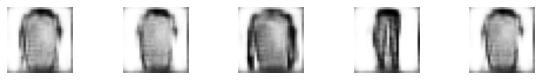

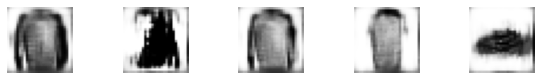

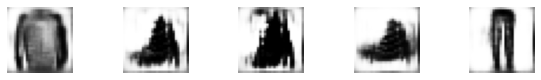

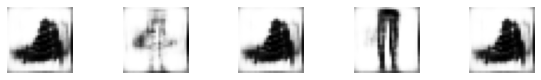

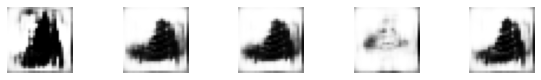

Epoch:14, Step:0, C-Loss:-0.070, G-Loss:0.256
Epoch:14, Step:50, C-Loss:-0.075, G-Loss:0.219
Epoch:14, Step:100, C-Loss:-0.133, G-Loss:0.247
Epoch:14, Step:150, C-Loss:-0.107, G-Loss:0.414
Epoch:14, Step:200, C-Loss:-0.081, G-Loss:0.240
Epoch:14, Step:250, C-Loss:-0.141, G-Loss:0.336
Epoch:14, Step:300, C-Loss:-0.099, G-Loss:0.445
Epoch:14, Step:350, C-Loss:-0.121, G-Loss:0.371
Epoch:14, Step:400, C-Loss:-0.080, G-Loss:0.309
Epoch:14, Step:450, C-Loss:-0.132, G-Loss:0.226


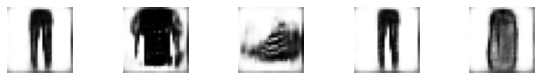

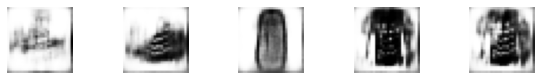

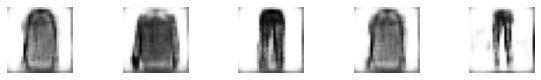

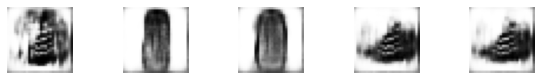

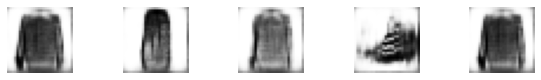

Epoch:15, Step:0, C-Loss:-0.085, G-Loss:0.300
Epoch:15, Step:50, C-Loss:-0.090, G-Loss:0.220
Epoch:15, Step:100, C-Loss:-0.068, G-Loss:0.274
Epoch:15, Step:150, C-Loss:-0.062, G-Loss:0.116
Epoch:15, Step:200, C-Loss:-0.083, G-Loss:0.132
Epoch:15, Step:250, C-Loss:-0.104, G-Loss:0.384
Epoch:15, Step:300, C-Loss:-0.093, G-Loss:0.251
Epoch:15, Step:350, C-Loss:-0.066, G-Loss:0.177
Epoch:15, Step:400, C-Loss:-0.096, G-Loss:0.298
Epoch:15, Step:450, C-Loss:-0.129, G-Loss:0.280


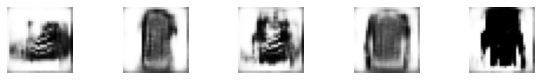

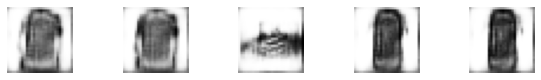

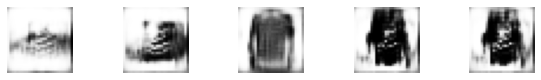

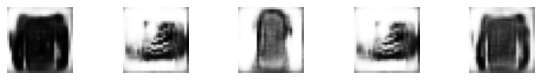

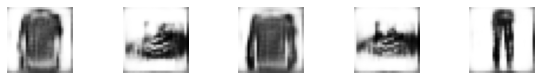

Epoch:16, Step:0, C-Loss:-0.068, G-Loss:0.225
Epoch:16, Step:50, C-Loss:-0.065, G-Loss:0.331
Epoch:16, Step:100, C-Loss:-0.096, G-Loss:0.357
Epoch:16, Step:150, C-Loss:-0.120, G-Loss:0.347
Epoch:16, Step:200, C-Loss:-0.122, G-Loss:0.248


KeyboardInterrupt: ignored

In [29]:
epochs = 500
batch_size = 100
steps = 500
noise_size = 100

for i in range(0, epochs):
    if (i%1 == 0):
        op = show_generator_results(generator_network)
        #print (op)
    for j in range(steps):
        # With Number of Critics=5
        for _ in range(5):
            fake_samples = get_fake_samples(generator_network, batch_size//2, noise_size)
            real_samples = get_real_samples(batch_size=batch_size//2)

            fake_y = np.ones((batch_size//2, 1))
            real_y = -1 * np.ones((batch_size//2, 1))

            # Updating Critic weights

            critic_network.trainable=True
            loss_c_real = critic_network.train_on_batch(real_samples, real_y)
            loss_c_fake = critic_network.train_on_batch(fake_samples, fake_y)
            
            loss_c = np.add(loss_c_real, loss_c_fake)/2.0

            # Clip critic weights
            for l in critic_network.layers:
                weights = l.get_weights()
                weights = [np.clip(w, -0.01, 0.01) for w in weights]
                l.set_weights(weights)
            
            if False:
                print ("C_real_loss: %.3f, C_fake_loss: %.3f, C_loss: %.3f"%(loss_c_real[0], loss_c_fake[0], loss_c[0]))
        
        noise_batches = get_random_noise(batch_size, noise_size)
        
        wgan_input = noise_batches
        
        # Make the Discriminator belive that these are real samples and calculate loss to train the generator
        wgan_output = -1 * np.ones((batch_size, 1))
        
        # Updating Generator weights
        critic_network.trainable=False
        loss_g = wgan_model.train_on_batch(wgan_input, wgan_output)
        
        if j%50 == 0:
            print ("Epoch:%.0f, Step:%.0f, C-Loss:%.3f, G-Loss:%.3f"%\
                   (i,j,loss_c[0] ,loss_g))